In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
train_data = pd.read_csv('..\\data\\california-house-prices\\train.csv')
test_data = pd.read_csv('..\\data\\california-house-prices\\test.csv')

In [3]:
print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [4]:
print(train_data.head())

   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   
4   4  7415 O Donovan Rd   1175000.0   

                                             Summary          Type  \
0  540 Pine Ln, Los Altos, CA 94022 is a single f...  SingleFamily   
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  SingleFamily   
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...  SingleFamily   
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  SingleFamily   
4  Beautiful 200 acre ranch land with several pas...    VacantLand   

   Year built                                       Heating  \
0      1969.0  Heating - 2+ Zones, Central Forced Air - Gas   
1      1926.0                                   Combination   
2      1958.0                                    Forced air   
3      1947.0                                       Central   
4         NaN          

In [5]:
train_data.columns

Index(['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built',
       'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms',
       'Full bathrooms', 'Total interior livable area', 'Total spaces',
       'Garage spaces', 'Region', 'Elementary School',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School', 'Middle School Score', 'Middle School Distance',
       'High School', 'High School Score', 'High School Distance', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Tax assessed value',
       'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On',
       'Last Sold Price', 'City', 'Zip', 'State'],
      dtype='object')

In [6]:
test_data.columns

Index(['Id', 'Address', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling',
       'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'Middle School', 'Middle School Score',
       'Middle School Distance', 'High School', 'High School Score',
       'High School Distance', 'Flooring', 'Heating features',
       'Cooling features', 'Appliances included', 'Laundry features',
       'Parking features', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City',
       'Zip', 'State'],
      dtype='object')

In [7]:
train_label = train_data['Sold Price']

In [8]:
data = pd.concat((train_data.iloc[:,4:-1],test_data.iloc[:,3:-1]))
print(data.shape)

(79065, 36)


In [9]:
numeric_features = data.dtypes[data.dtypes != 'object'].index
data[numeric_features] = data[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
data[numeric_features] = data[numeric_features].fillna(0)
print(data.head())

           Type  Year built                                       Heating  \
0  SingleFamily    0.048505  Heating - 2+ Zones, Central Forced Air - Gas   
1  SingleFamily   -0.284656                                   Combination   
2  SingleFamily   -0.036722                                    Forced air   
3  SingleFamily   -0.121949                                       Central   
4    VacantLand    0.000000                                           NaN   

                                             Cooling  \
0    Multi-Zone, Central AC, Whole House / Attic Fan   
1  Wall/Window Unit(s), Evaporative Cooling, See ...   
2                                                NaN   
3                                        Central Air   
4                                                NaN   

                                         Parking       Lot  \
0             Garage, Garage - Attached, Covered -0.018489   
1                       Detached Carport, Garage -0.018287   
2             

In [10]:
miss_values_count = data[numeric_features].isnull().sum()
miss_values_count.loc[miss_values_count > 0]

Series([], dtype: int64)

In [11]:
object_features = data.dtypes[data.dtypes == 'object'].index
print(object_features)

Index(['Type', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Region',
       'Elementary School', 'Middle School', 'High School', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Listed On', 'Last Sold On',
       'City'],
      dtype='object')


In [12]:
data['Last Sold On'] = pd.to_datetime(data['Last Sold On'],format = '%Y-%m-%d')
data['Listed On'] = pd.to_datetime(data['Listed On'],format = '%Y-%m-%d')

In [13]:
print(data['Last Sold On'].head())
print(data['Last Sold On'].min())
print(data['Listed On'].head())
print(data['Listed On'].min())

0          NaT
1   2019-08-30
2          NaT
3   2016-08-30
4   2016-06-27
Name: Last Sold On, dtype: datetime64[ns]
1961-11-06 00:00:00
0   2019-10-24
1   2019-10-16
2   2019-08-25
3   2019-10-24
4   2019-06-07
Name: Listed On, dtype: datetime64[ns]
2007-03-11 00:00:00


In [14]:
data['Last Sold On'] = ((data['Last Sold On'] - data['Last Sold On'].min()).fillna(pd.to_timedelta('0day'))).dt.days
data['Last Sold On'].head()

0        0
1    21116
2        0
3    20021
4    19957
Name: Last Sold On, dtype: int64

In [15]:
data['Listed On'] = ((data['Listed On'] - data['Listed On'].min()).fillna(pd.to_timedelta('0day'))).dt.days
data['Listed On'].head()

0    4610
1    4602
2    4550
3    4610
4    4471
Name: Listed On, dtype: int64

In [16]:
data_train = data.copy()

In [17]:
object_features = object_features.drop(['Listed On', 'Last Sold On'])
object_features

Index(['Type', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Region',
       'Elementary School', 'Middle School', 'High School', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'City'],
      dtype='object')

In [18]:
for i in object_features:
    feature_dict = dict(zip(data[i].unique(),range(len(data[i].unique()))))
    data[i] = (data[i].map(feature_dict) + 1).fillna(0)
data[object_features].head()

,Type,Heating,Cooling,Parking,Bedrooms,Region,Elementary School,Middle School,High School,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,City
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,1,3,3,3,3,3,3,1,3,2,3,3,2,3,3,3
3,1,4,4,4,4,4,4,3,4,3,4,4,3,4,4,4
4,2,5,3,3,5,5,5,4,5,2,5,3,2,3,3,5


In [19]:
miss_values_count = data.isnull().sum()
miss_values_count.loc[miss_values_count > 0]

Series([], dtype: int64)

In [20]:
data = data.astype(float)

In [21]:
data.nunique()

Type                             174
Year built                       170
Heating                         2660
Cooling                          911
Parking                         9913
Lot                            11966
Bedrooms                         278
Bathrooms                         25
Full bathrooms                    18
Total interior livable area     5297
Total spaces                      68
Garage spaces                     58
Region                          1259
Elementary School               3568
Elementary School Score           11
Elementary School Distance       269
Middle School                    809
Middle School Score               11
Middle School Distance           255
High School                      922
High School Score                 11
High School Distance             360
Flooring                        1740
Heating features                1763
Cooling features                 596
Appliances included            11290
Laundry features                3031
P

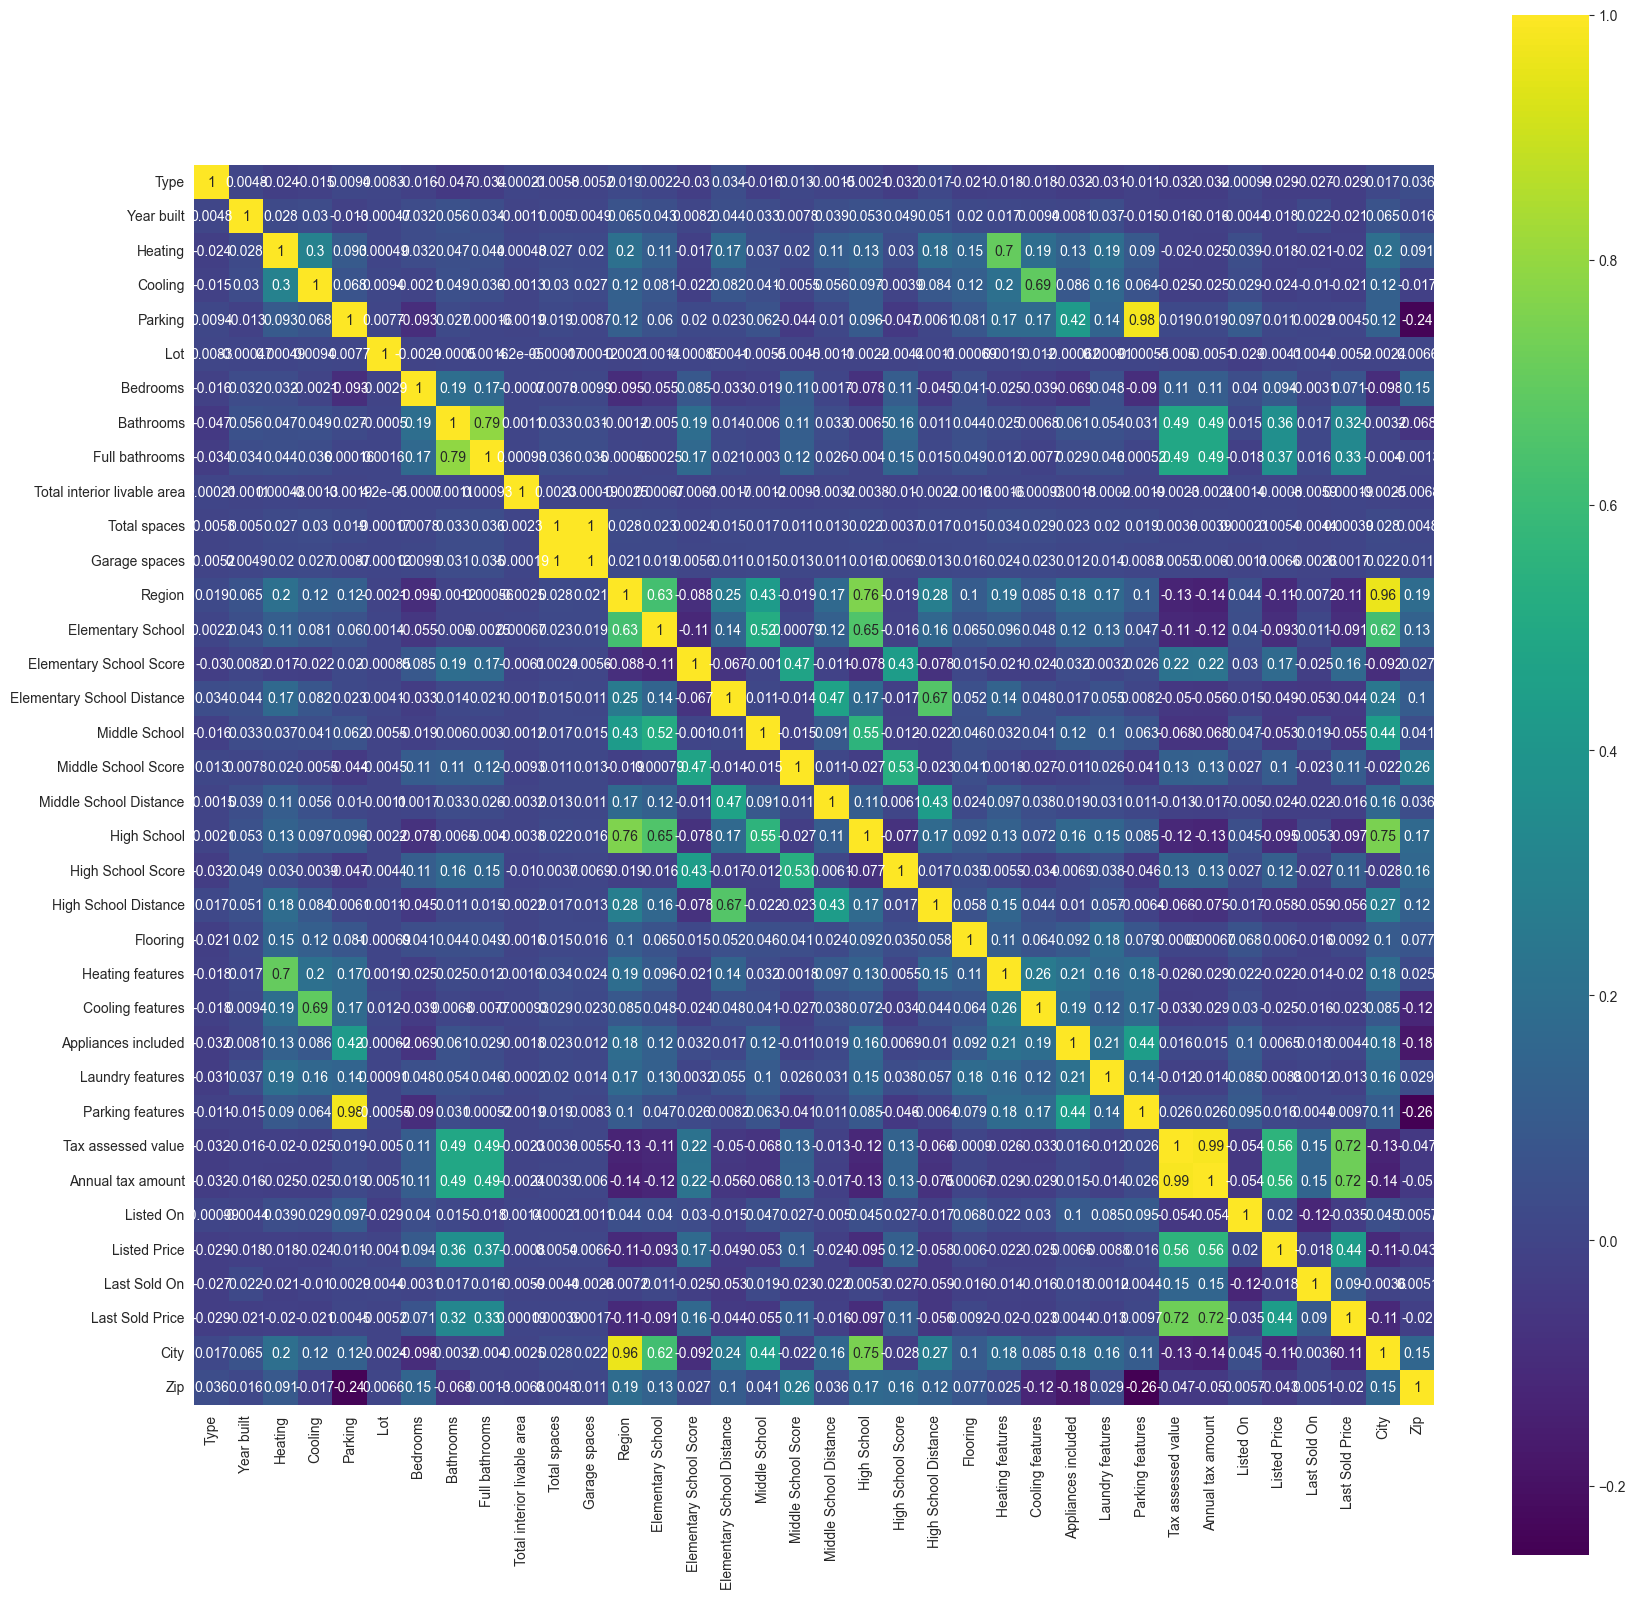

In [22]:
colormap = plt.cm.viridis
plt.figure(figsize = (20,20))
a = data[:train_data.shape[0]]
sns.heatmap(a.corr(), square = True, cmap = colormap, 
            linecolor = 'white', annot = True)
plt.show()

In [23]:
# 导入XGBClassifier模型   
from xgboost import XGBRegressor
xgb = XGBRegressor(random_state=0)   
X_train = data[:train_data.shape[0]]
y_train = train_label
feature_names = X_train.columns

In [24]:
xgb.fit(X_train, y_train)      
# 获取特征重要性   
importances = xgb.feature_importances_      
# 创建包含特征及其重要性的数据帧   
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importances})      
# 按重要性降序排序   
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

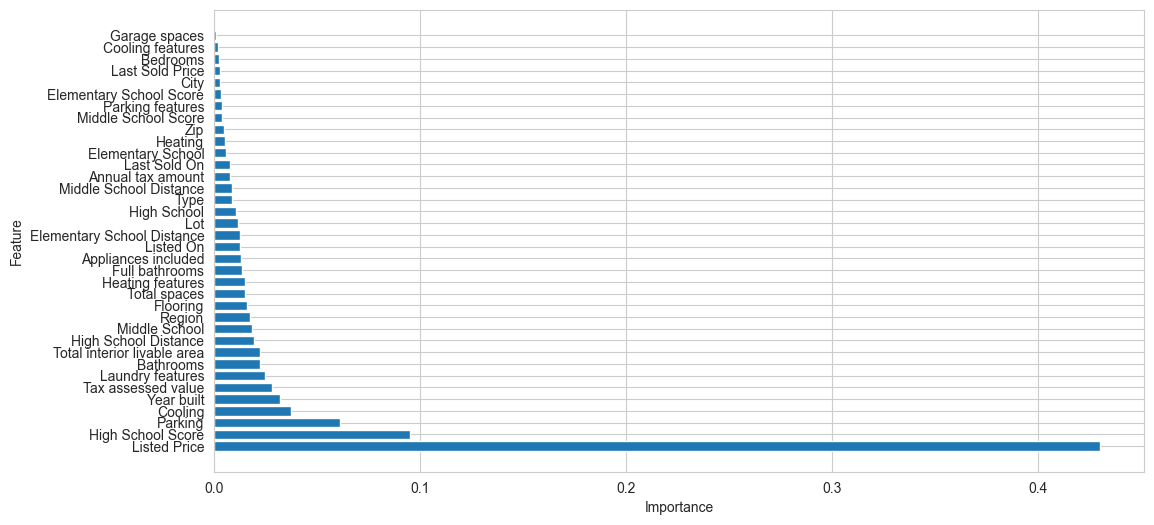

In [25]:
# 创建从基于树的模型获取的特征重要性的条形图   
plt.figure(figsize=(12, 6))   
plt.barh(feature_importance['feature'], feature_importance['importance'])   
plt.xlabel('Importance')   
plt.ylabel('Feature')   
plt.show()   

In [26]:
feature_last = list()
for i in range(len(feature_importance['feature'])):
    if feature_importance['importance'][i] > 0.02:
        feature_last.append(feature_importance['feature'][i])
print(feature_last)
if 'Parking' in feature_last:
    feature_last.remove('Parking')

['Year built', 'Cooling', 'Parking', 'Bathrooms', 'Total interior livable area', 'High School Score', 'Laundry features', 'Tax assessed value', 'Listed Price']


In [27]:
data = data_train[feature_last]
data = pd.get_dummies(data, dummy_na=True)
data.shape

(79065, 3948)

In [28]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [29]:
data = data.astype(float)
n_train = train_data.shape[0]
train_features = torch.tensor(data[:n_train].values, dtype=torch.float32,device=try_gpu())
test_features = torch.tensor(data[n_train:].values, dtype=torch.float32,device=try_gpu())
train_labels = torch.tensor(train_label.values.reshape(-1, 1), dtype=torch.float32,device=try_gpu())

In [38]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    # net = nn.Sequential(nn.Linear(in_features, 1))
    # net = nn.Sequential(nn.Linear(in_features,256), nn.ReLU(), nn.Linear(256,1))
    net = nn.Sequential(nn.Linear(in_features,512), nn.ReLU(), nn.Dropout(0.2),
                        nn.Linear(512,256), nn.ReLU(), nn.Dropout(0.5),nn.Linear(256,1))
    net = net.to(device=try_gpu())
    
    return net

In [31]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [32]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []   # train_loss和test_loss
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，对初始学习率没有那么敏感
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [33]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [34]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [35]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    net = net.to(device=try_gpu())
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).cpu().detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

fold 1, train log rmse 0.391580, valid log rmse 0.479723
fold 2, train log rmse 0.413320, valid log rmse 0.492774
fold 3, train log rmse 0.422257, valid log rmse 0.520235
fold 4, train log rmse 0.315614, valid log rmse 0.486374
fold 5, train log rmse 0.366902, valid log rmse 0.462338
5-折验证: 平均训练log rmse: 0.381935, 平均验证log rmse: 0.488289


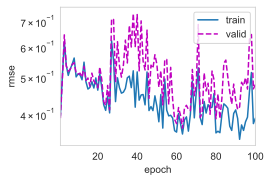

In [40]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0.1, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train log rmse 0.349012


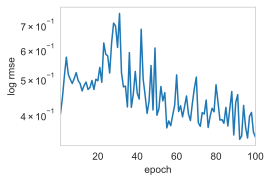

In [41]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)